In [36]:
!nvidia-smi

Tue Jan 18 20:52:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
import os
import math
import keras
import numpy as np
from skimage import io
from sys import getsizeof
from tensorflow import keras
from collections import Counter
from skimage.transform import rescale
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [14]:
seed = 7
np.random.seed(seed)

In [3]:
data_path = '/content/drive/MyDrive/Newcastle University/Machine Learning/lesions'

In [26]:
def load_paths(path):
  
  image_paths = []
  y = []
  
  for label, elem in enumerate(os.listdir(path)):

    print('class: ' + elem + ' | label: ' + str(label))
    path1 = path + '/' + elem
    images = os.listdir(path1)
    for im in images:
      image_paths.append(path1 + '/' + im)
      y.append(str(label))
  
  # shuffle
  c = list(zip(image_paths,y))
  np.random.shuffle(c)
  image_paths,y = zip(*c)
  
  return image_paths, keras.utils.to_categorical(y, num_classes=7)

image_paths, labels = load_paths(data_path)

class: nv | label: 0
class: bcc | label: 1
class: akiec | label: 2
class: df | label: 3
class: bkl | label: 4
class: vasc | label: 5
class: mel | label: 6


In [27]:
x_train, x_test, y_train, y_test = train_test_split(image_paths, labels, test_size = 0.2, random_state = 42)

In [33]:
x_test.[17]

(2003, 7)

In [31]:
y_test[17]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
Counter(y_test).keys() # equals to list(set(words))

In [ ]:
Counter(y_test).values() # counts the elements' frequency

In [74]:
class LeisonSequence(keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size = 32):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        images = []

        for file_name in batch_x:
          images.append(rescale(io.imread(file_name), (0.3, 0.3, 1)))

        return np.array(images), np.array(batch_y)

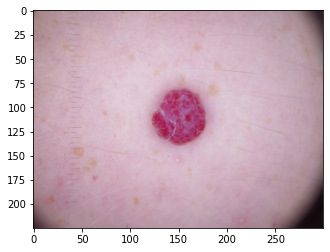

In [73]:
from matplotlib import pyplot as plt
test = []

for file_name in x_test[0:5]:
  test.append(rescale(io.imread(file_name), (0.5, 0.5, 1)))
  #print(file_name)

test = np.array(test)
plt.imshow(test[3])

In [75]:
train_img_gen = LeisonSequence(x_train, y_train, 50)
val_img_gen = LeisonSequence(x_test, y_test, 32)

In [76]:
model = keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(135, 180, 3),
    pooling=None,
    classes=7,
    classifier_activation="softmax",
)

In [77]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 225, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 75, 128)       0     

In [78]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = keras.optimizers.SGD(learning_rate=lr_schedule)
adam = keras.optimizers.Adam(learning_rate=lr_schedule, amsgrad=True)
nadam = keras.optimizers.Nadam(learning_rate=lr_schedule)

In [79]:
model.compile(loss='categorical_crossentropy', optimizer=nadam ,metrics=['accuracy'])

In [80]:
cp = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Newcastle University/Machine Learning/Models', verbose = 1, save_best_only = True, monitor='val_accuracy')

In [ ]:
history = model.fit(train_img_gen, epochs=50, validation_data=val_img_gen, callbacks=cp)

Epoch 1/50
161/161 [==============================] - ETA: 0s - loss: 1.1785 - accuracy: 0.6710
Epoch 00001: val_accuracy improved from -inf to 0.66350, saving model to /content/drive/MyDrive/Newcastle University/Machine Learning/Models
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Newcastle University/Machine Learning/Models/assets
161/161 [==============================] - 684s 4s/step - loss: 1.1785 - accuracy: 0.6710 - val_loss: 1.1500 - val_accuracy: 0.6635
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 1.1351 - accuracy: 0.6710
Epoch 00002: val_accuracy did not improve from 0.66350
161/161 [==============================] - 679s 4s/step - loss: 1.1351 - accuracy: 0.6710 - val_loss: 1.1598 - val_accuracy: 0.6635
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 1.1256 - accuracy: 0.6710
Epoch 00003: val_accuracy did not improve from 0.66350
161/161 [==============================] - 669s 4s/step - loss: 1.1256 - accuracy: 0.67

seed = 7
np.random.seed(seed)

def data_loader(path_train):
  train_list0=os.listdir(path_train)
  
  # Map class names to integer labels
  # train_class_labels = { label: index for index, label in enumerate(class_names) }
  
  # Number of classes in the dataset
  num_classes=len(train_list0)
  
  # Empty lists for loading training and testing data images as well as corresponding labels
  x=[]
  y=[]
  
  # Loading training data
  for label,elem in enumerate(train_list0):
    
    path1=path_train+'/'+str(elem)
    images=os.listdir(path1)
    for elem2 in images:
      path2=path1+'/'+str(elem2)
      
      # Read the image form the directory
      img = io.imread(path2)
      
      #MinMax Scaling
      #img=MinMaxScaler().fit_transform(img.reshape((-1, 3))).reshape(img.shape)
      # Append image to the train data list
      x.append(img)
      # Append class-label corresponding to the image
      y.append(str(label))
    
    print(getsizeof(x))
  
  # Convert lists into numpy arrays
  c = list(zip(x,y))
  np.random.shuffle(c)
  x,y = zip(*c)
  
  x = np.asarray(x)
  y = np.asarray(y)
  
  print(getsizeof(x))

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)
  
  return x_train,y_train,x_test,y_test

In [ ]:
# Loading the data

X_train,y_train,X_test,y_test=data_loader(data_path)

54576
61440
61440
61440
77856
77856
87632


In [1]:
sum([54576, 61440, 61440, 61440, 77856, 77856, 87632])

482240